## Convergence and Stability

Let's put these ideas to use to design a numerical scheme whose solution should approximate the solution of a PDE. Along the way, we'll need to do some work to guarantee that the numerical solution actually converges to the real solution. 

For the time being, our PDE will be the  heat equation (with parameter 1) in one dimension:
$$ u_t = u_{xx}.$$
Adding a parameter for heat conductivity adds notational complexity without much educational value. In most places, it will be completely clear how the analysis would change if there were a parameter for conductivity. The heat equation is the archetypical *parabolic* PDE.

In this text, a lowercase $u$ will denote an exact solution to the PDE at hand, while a capital $U$ is reserved for numerical approximations. A problem for this PDE involves specifying the temperature at each point on a one-dimensional rod at time $0$. To ensure uniqueness of the (true) solution, some sort of boundary conditions need to be imposed which specify the behavior at the ends of the rod. Typical boundary conditions at an end of the rod fall into two categories. One is to specify that the end is at a fixed temperature (which may be a function of time). The other is to specify the derivative of temperature at the end of the rod. Physically, this corresponds to how much heat is flowing from the environment into the rod. Imagine a heating element is placed at the end of the rod which adds heat at some rate. In PDE lingo, these two types of boundary conditions have names: specifying the value of $u$ at the boundary is a *Dirichlet boundary condition*, and specifying the derivative of $u$ at the boundary is a *Neumann boundary condition*. In some PDEs, it is necessary to specify both simultaneously. Or sometimes, a linear combination of these boundary conditions can be imposed (e.g., the sum of the value and derivative on the boundary is 0).

The basic idea behind the *finite difference method*, which we will be using to numerically solve PDEs, is to discretize space and time and use the discrete derivative approximations on this discretization. Some notation will help facilitate this, and this notation will be used consistently throughout this text.

Suppose the domain of interest has $0 \leq x \leq a$ and we care about time $0 \leq t \leq T$. Fix $\Delta x$ and $\Delta t$ to be the grid spacing in the $x$ and $t$ dimensions. Let $J+1$ be the number of grid points (so there will be $J$ intervals) in the $x$ direction and $N+1$ be the number in the $t$ direction. Then we set $x_i = i \Delta x$, so that $x_0 = 0$ and $x_J = J \Delta x = a$; similarly, $t_n = n \Delta t$, so that $t_0 = 0$ and $t_N = N \Delta t = T$. For other rectangular domains, similar definitions can be made.

With this, we define $u^n_i$ to mean $u(x_i, t_n) = u(i \Delta x, n \Delta t)$. This is the exact solution evaluated at the grid point $(x_i, t_n)$. More generally, for a function $f$, the notation $f^n_i$ means $f(x_i, t_n)$. Parentheses may be added for clarity. For example, $(u_{xx})^n_i$ is nicer than ${u_{xx}}^n_i$. We will define $U^n_i$ in such a way that (we hope) it is a good approximation to $u^x_i$ when $\Delta x$ and $\Delta t$ are small. 

Let's start with our first scheme. Recall that we are interested in the heat equation $u_t = u_{xx}$. At the grid point $(x_i, t_n)$, we will approximate $u_t$ with a forward difference and $u_{xx}$ with the standard second derivative approximation:
$$
(u_t)^n_i = \frac{u^{n+1}_i - u^n_i}{\Delta t} + O(\Delta t),
$$
$$
(u_{xx})^n_i = \frac{u^n_{i-1} - 2 u^n_i + u^n_{i+1}}{\Delta x^2} + O(\Delta x^2).
$$
Thus,
$$
\frac{u^{n+1}_i - u^n_i}{\Delta t} - \frac{u^n_{i-1} - 2 u^n_i + u^n_{i+1}}{\Delta x^2} = u_t - u_{xx} + O(\Delta t + \Delta x^2).
$$
Of course, $u_t - u_{xx} = 0$, since $u$ satisfies the heat equation, so we see that $\frac{u^{n+1}_i - u^n_i}{\Delta t} - \frac{u^n_{i-1} - 2 u^n_i + u^n_{i+1}}{\Delta x^2} = O(\Delta t + \Delta x^2)$. The right hand size is small if $\Delta t$ and $\Delta x$ are small, so if we want $U \approx u$, we might define $U$ to satisfy $\frac{U^{n+1}_i - U^n_i}{\Delta t} = \frac{U^n_{i-1} - 2 U^n_i + U^n_{i+1}}{\Delta x^2}$. We call such an equation a *scheme* for the PDE. If we know $U^n_j$ for all $j$, then we can solve this equation for $U^{n+1}_i$. Since we can do that, we call this an *explicit* scheme. We have
$$
\begin{align*}
U^{n+1}_i &= U^n_i + \frac{\Delta t}{\Delta x^2}(U^n_{i-1} - 2 U^n_i + U^n_{i+1})\\
          &= r U^n_{i-1} + (1-2r) U^n_i + r U^n_{i+1}, 
\end{align*}
$$
where $r = \Delta t/\Delta x^2$.

Notice that all we have really done is take the PDE, replace the derivatives with discrete approximations, and replace $u$ with $U$. Coming up with schemes for PDEs is not necessarily hard; in general, analyzing the performance of a scheme may be the hard part. This scheme as written is not a complete description that would allow us to compute $U$ (given some initial condition) because the boundary conditions have not been specified. The scheme we have written is not even well-defined for $i = 0$ or $i = J$, because it would rely on the grid points $U^n_{-1}$ and $U^n_{J+1}$, which don't exist. Let's use Dirichlet (specifying the value) boundary conditions of $0$. Thus, instead of defining $U^n_0$ and $U^n_J$ by our scheme equation, we will set $U^n_0 = U^n_J = 0$. And we will use initial conditions of $u(x, 0) = \sin(x)$ on $0 \leq x \leq \pi$. We can start with $T = 1$. Let's code this.

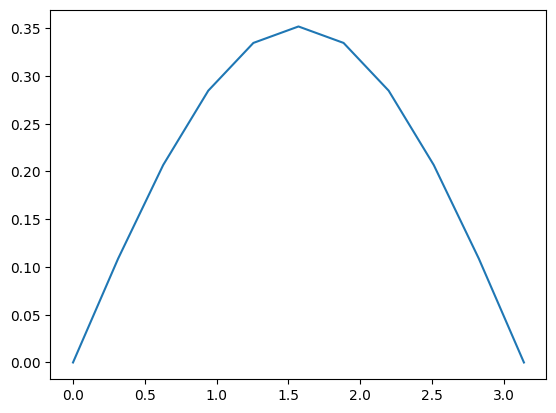

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def explicit_heat(T, J, N):
    # Returns the numerical solution at time T to the heat equation 
    # on [0, pi] with initial conditions sin(x),
    # Dirichlet boundary conditions of 0, and
    # J spacial and N time steps using the explicit scheme.
    a = np.pi
    x = np.linspace(start = 0, stop = a, num = J + 1, endpoint = True)
            # This creates an array of J+1 elements equally spaced between
            # start and stop, with the right endpoint included
    U = np.sin(x) # initial conditions
        
    dx = a/J
    dt = T/N
    r = dt/(dx*dx)
    
    for i in range(N):
        U_next = r*np.roll(U, 1) + (1-2*r)*U + r*np.roll(U, -1)
                # roll shifts the elements of the array (and warps the array
                # around when the elements at the end spill over).
                # So np.roll(U, 1) shifts the elements 1 to the right, and the
                # i-th element of this is U_{i-1}.
        U_next[0] = 0
        U_next[J] = 0
        U = U_next
        
    return x, U # In python, you can return two values like this

x, U = explicit_heat(1, 10, 10)

plt.plot(x, U)
plt.show()

We have a nice numerical simulation of our PDE. Notice that it basically looks like the sine function we started with, except that its amplitude is about $0.35$ instead of $1$. The graph looks a bit rough since we didn't use many grid points. Let's try bumping the number of grid points up from $10$ to $100$. 

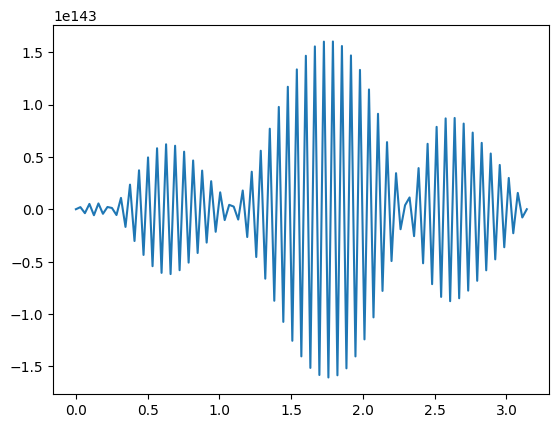

In [26]:
x, U = explicit_heat(T = 1, J = 100, N = 100)
plt.plot(x, U)
plt.show()

Something has gone very wrong. We expect that increasing the number of grid points should improve the accuracy of the numerical scheme, but it ruined it instead. The problem is that the scheme is not numerically stable. 